## Contents:
* [Loading packages](#Loading_packages)
* [Reading cell2location model output and defining useful functions](#read)

* [Fig 3E](#Fig3E)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


### Reading cell2location model output and defining useful functions <a class="anchor" id="read"></a> 

In [2]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

run_name = 'CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
#adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [3]:
# annotate region clusters
region_annot = pd.read_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_copy.csv')
region_annot = region_annot.loc[~region_annot['region_04092020'].isna(),:]
region_annot.index = region_annot['region_04092020'].astype(int).astype(str)
region_annot['region_final'] = region_annot['region_final'].astype(int).astype(str)
region_annot.index.name = 'region_cluster'
region_annot = region_annot.reindex(index = list(adata_vis.obs['region_cluster']))
region_annot.index = adata_vis.obs_names

adata_vis.obs[region_annot.columns] = region_annot

In [4]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y
    

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'region_final' as categorical
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


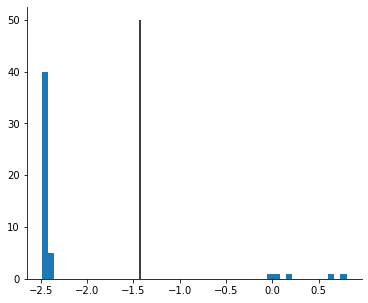

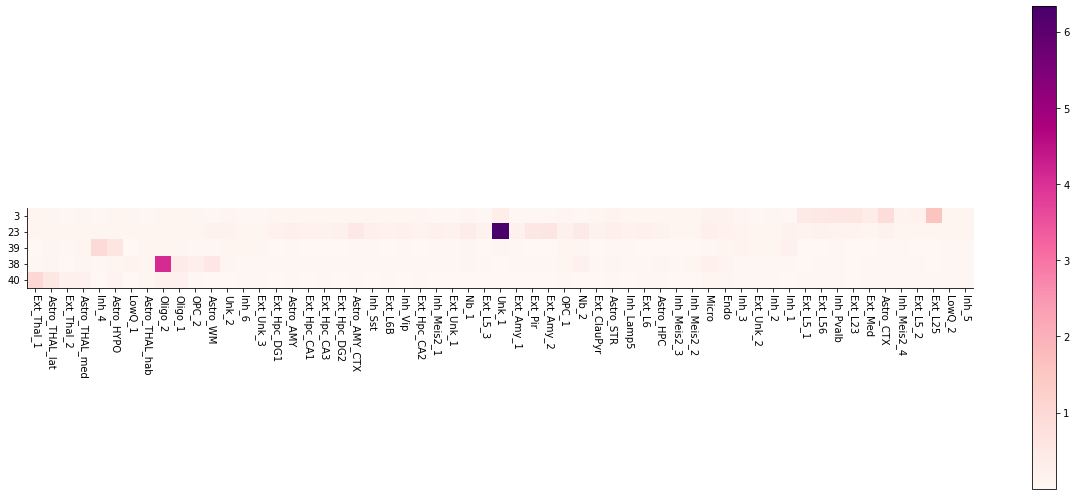

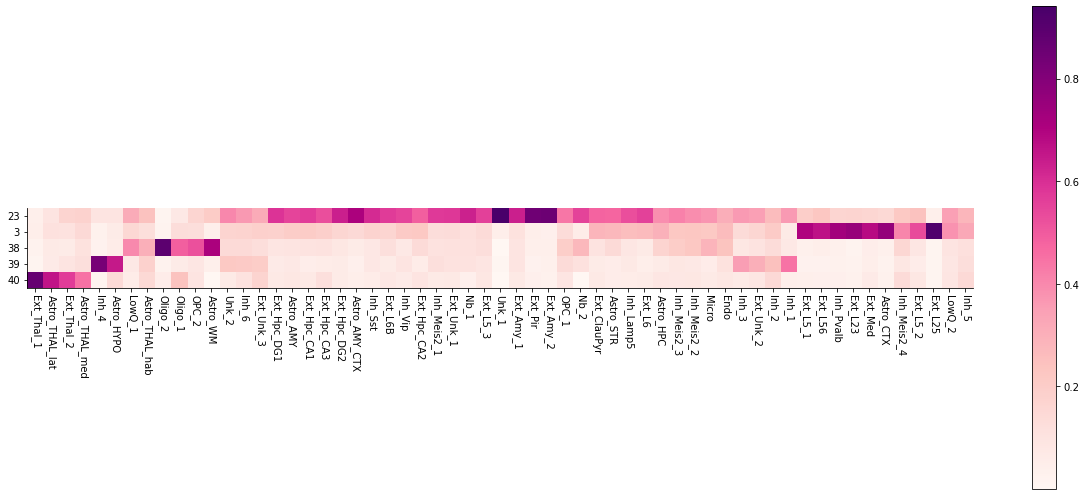

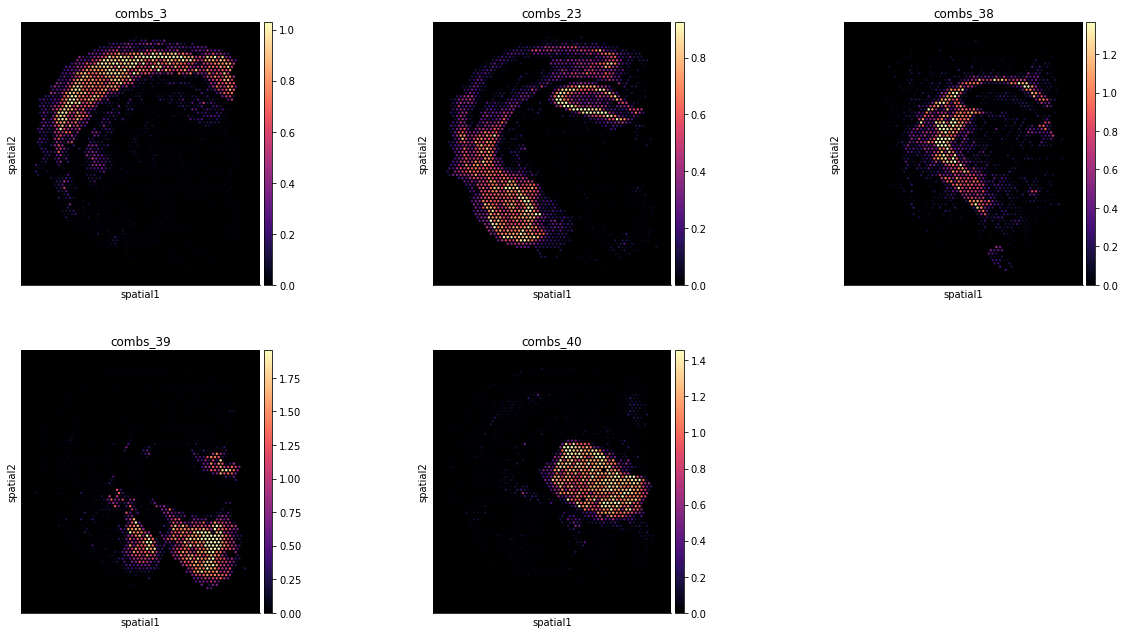

In [5]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['comb2fact'],
                            columns=adata_vis.uns['mod']['fact_names'])

rcParams["figure.figsize"] = [6, 5]
rcParams["axes.facecolor"] = "white"
plt.hist(np.log10(comb2fact_df.max(1)), bins=50);
thresh = 0.037
plt.vlines(np.log10(thresh), 0, 50);
fact_filt = comb2fact_df.max(1) > thresh

comb2fact_df = comb2fact_df.loc[fact_filt.values, :]

clustermap(comb2fact_df, figure_size=(17, 7))

comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df_prop, figure_size=(17, 7))

n_combs = adata_vis.uns['mod']['post_sample_means']['combs_factors'].shape[1]
combs_factors = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['combs_factors'],
                             columns=[f'combs_{i}' for i in range(n_combs)],
                             index=adata_vis.uns['mod']['obs_names'])
combs_factors = combs_factors.loc[:, fact_filt.values]
adata_vis.obs[combs_factors.columns] = combs_factors

slide = select_slide(adata_vis, 'ST8059048')
crop_x, crop_y = get_crop_coord(slide)

s = 'spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna'
rcParams["axes.facecolor"] = "black"
sc.pl.spatial(slide, cmap='magma',
              color=combs_factors.columns, # limit size in this notebook
              library_id=f'{s}',
              ncols=3, 
              size=1, img_key='hires', 
              alpha_img=0,
              vmin=0, vmax='p99.0'
             )

In [6]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata_vis[adata_vis.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

### Fig 3E <a class="anchor" id="Fig3E"></a> 

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'old_region' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'comments' as categorical


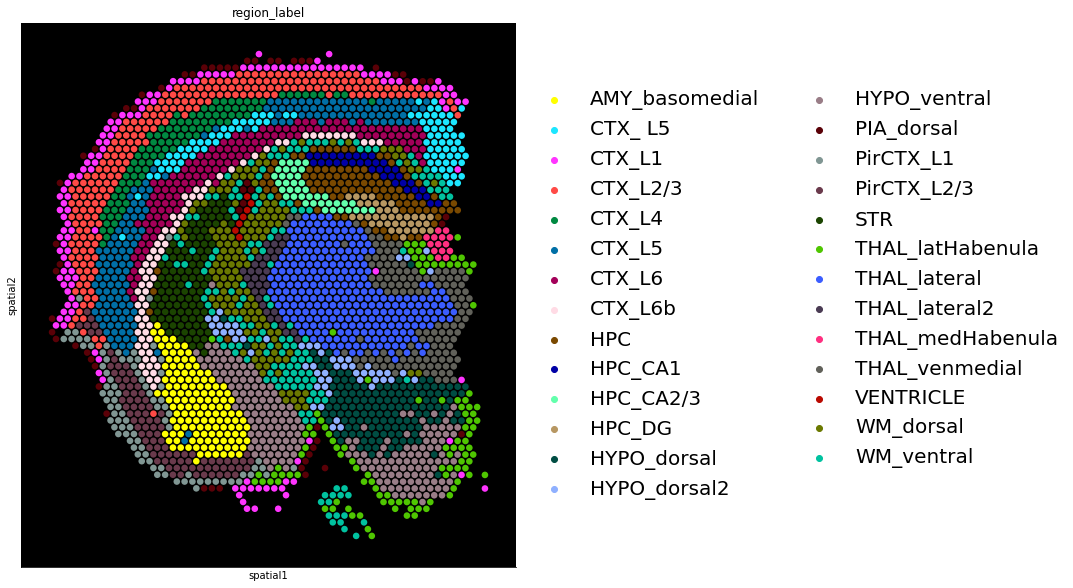

In [7]:
adata_vis = adata_vis[adata_vis.obs['region_final'].astype('int').argsort(),:]
adata_vis.obs['region_final'] = adata_vis.obs['region_final'].astype('category')
cat_order = adata_vis.obs['region_final'].cat.categories.astype(int).sort_values().astype('str')
adata_vis.obs['region_final'].cat.reorder_categories(cat_order, inplace=True)
adata_vis.obs['region_label'] = adata_vis.obs['region_label'].astype('category')
cat_order = adata_vis.obs['region_label'].cat.categories.sort_values().astype('str')
adata_vis.obs['region_label'].cat.reorder_categories(cat_order, inplace=True)
adata_vis.obs['location'] = adata_vis.obs['location'].astype('category')

s = 'ST8059048'
adata_vis = select_slide(adata_vis, s)
slide = select_slide(adata_vis, s)
crop_x, crop_y = get_crop_coord(slide)

with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):


    # Visualize cell type locations
    # making copy to transform to log & assign nice names
    sc.pl.spatial(adata_vis, #cmap='magma',
                  color=['region_label'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_2D_final_clusters.pdf',
                  palette=sc.pl.palettes.default_102
                 )

/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.uns` of view, copying.


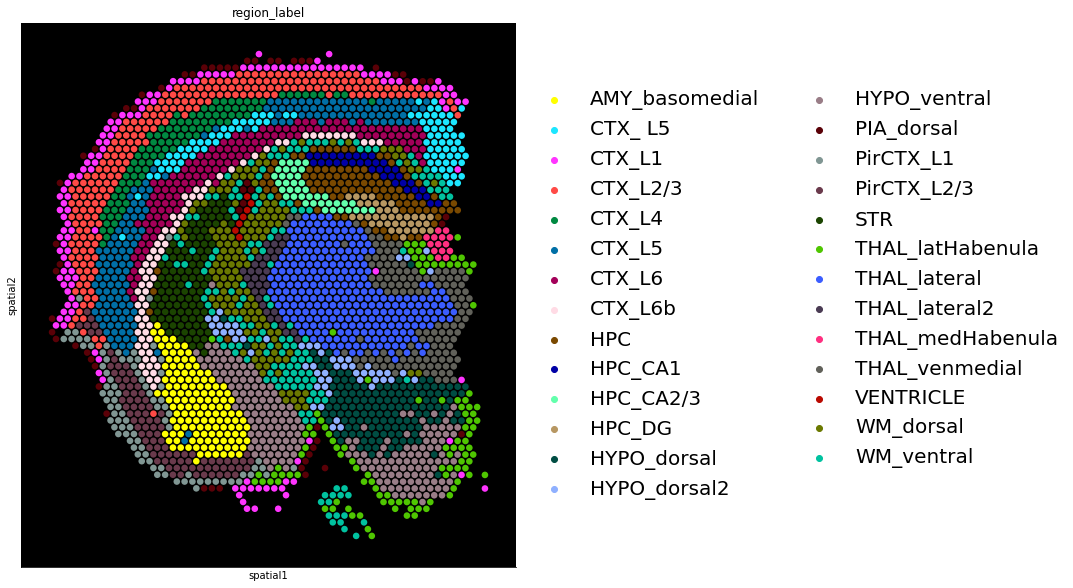

In [8]:
with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):

    for s in adata_vis.obs['sample'].unique():
        slide = select_slide(adata_vis, s)
        crop_x, crop_y = get_crop_coord(slide)
        # Visualize cell type locations
        # making copy to transform to log & assign nice names
        sc.pl.spatial(slide, #cmap='magma',
                      color=['region_label'], ncols=4, 
                      #library_id=s,
                      size=1.3, img_key='hires', alpha_img=0,
                      frameon=True, legend_fontsize=20,
                      #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                      vmin=0, vmax='p99.5', #save='Fig3E_2D_final_clusters.pdf',
                      palette=sc.pl.palettes.default_102
                     )

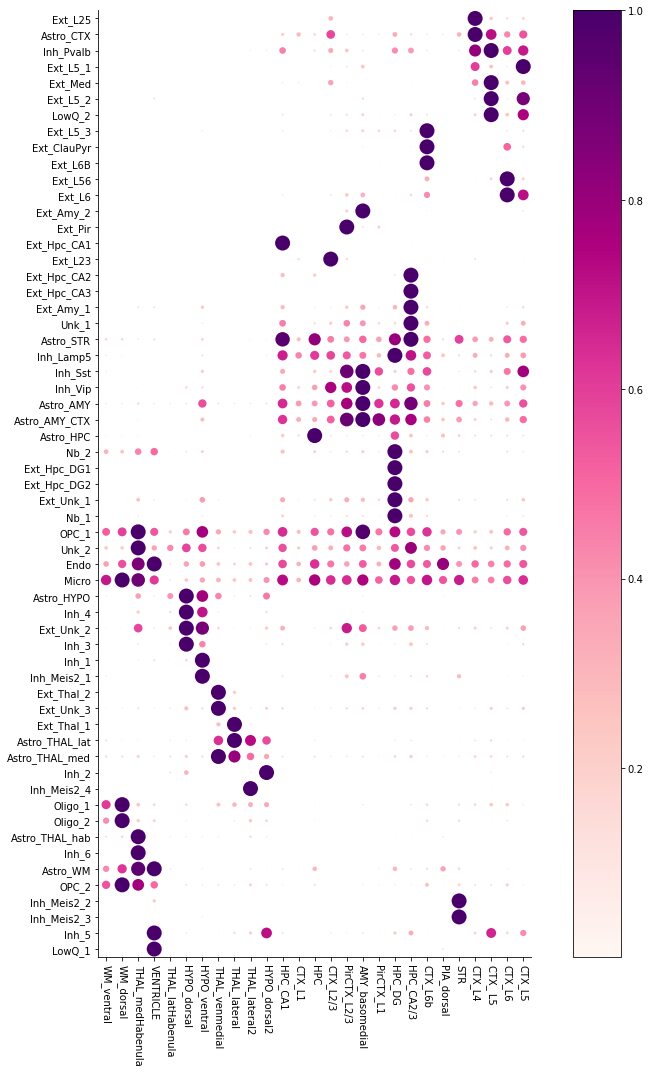

In [9]:
# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap

ct_aver = get_cluster_averages_df(X=adata_vis.obs[['mean_spot_factors' + i 
                                                      for i in adata_vis.uns['mod']['fact_names']]],
                        cluster_col=adata_vis.obs["region_label"])
ct_aver.index = adata_vis.uns['mod']['fact_names']

# normalise to get 10% of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=True, cluster_cols=True, figure_size=(12, 15))
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_suppl_final_clusters_dotplot_one_section.pdf',
                    bbox_inches='tight', facecolor='white')

#### Export the data to plot this heatmap in R

In [10]:
ct_aver = ct_aver.T
ct_aver['region_label'] = ct_aver.index

region_annot = pd.read_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_copy.csv')

region_annot2 = region_annot[['location', 'region_label']]
region_annot2.index = region_annot2['region_label']
region_annot2.index.name = None
region_annot2 = region_annot2.drop_duplicates()

ct_aver['location'] = region_annot2['location'][ct_aver.index]
ct_aver['region_label'] = region_annot2['region_label'][ct_aver.index]

ct_aver['region_label_colors'] = pd.Series(
    adata_vis.uns['region_label_colors'], 
    index=adata_vis.obs['region_label'].astype('category').cat.categories)[ct_aver.index]

ct_aver.to_csv(f'{sp_results_folder}{run_name}/20200904_region_cell_abundances_one_section.csv')
ct_aver

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_STR,Astro_THAL_hab,Astro_THAL_lat,Astro_THAL_med,Astro_WM,...,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2,Unk_1,Unk_2,region_label,location,region_label_colors
AMY_basomedial,1.000000,1.000000,0.108643,0.118492,0.084512,0.501131,0.048825,0.053086,0.138300,0.066725,...,0.205452,0.975789,0.090158,0.110807,0.020329,0.397111,0.460535,AMY_basomedial,amygdala,#ffff00
CTX_ L5,0.285982,0.136369,0.714976,0.139433,0.036945,0.326767,0.032267,0.168856,0.178796,0.038130,...,0.039800,0.258761,0.142796,0.240039,0.065277,0.053449,0.207813,CTX_ L5,cortex,#1ce6ff
CTX_L1,0.386488,0.327821,0.290760,0.153775,0.017859,0.273006,0.024800,0.025263,0.051052,0.073334,...,0.063769,0.269941,0.014481,0.010294,0.004480,0.066765,0.219282,CTX_L1,cortex,#ff34ff
CTX_L2/3,0.521301,0.522846,0.579839,0.131928,0.023674,0.456746,0.027095,0.051421,0.109410,0.035632,...,0.125575,0.479041,0.045009,0.026236,0.008067,0.219697,0.326280,CTX_L2/3,cortex,#ff4a46
CTX_L4,0.360178,0.198006,1.000000,0.143997,0.038637,0.382314,0.032774,0.132280,0.181887,0.024364,...,0.044087,0.223655,0.143259,0.180807,0.028919,0.038107,0.253877,CTX_L4,cortex,#008941
CTX_L5,0.555654,0.490655,0.548435,0.130785,0.035669,0.487449,0.035722,0.081742,0.157218,0.037885,...,0.123593,0.541500,0.090666,0.100086,0.017860,0.325726,0.415164,CTX_L5,cortex,#006fa6
CTX_L6,0.394444,0.296067,0.429483,0.145592,0.030518,0.537589,0.039395,0.075599,0.139145,0.087579,...,0.142824,0.495823,0.213458,0.230559,0.115488,0.215979,0.319704,CTX_L6,cortex,#a30059
CTX_L6b,0.456306,0.443816,0.104588,0.112969,0.031317,0.488411,0.048879,0.038564,0.103846,0.157201,...,0.216774,0.627978,0.263486,0.176587,0.171906,0.328302,0.420141,CTX_L6b,cortex,#ffdbe5
HPC,0.392381,0.341243,0.177141,1.000000,0.047799,0.813155,0.064437,0.103945,0.144849,0.300666,...,0.198216,0.548207,0.148087,0.072448,0.072665,0.150509,0.377412,HPC,hippocampus,#7a4900
HPC_CA1,0.650245,0.625625,0.208212,0.232819,0.032532,0.964066,0.038745,0.062389,0.139773,0.120397,...,0.275162,0.648003,0.085599,0.060124,0.032646,0.450763,0.560288,HPC_CA1,hippocampus,#0000a6


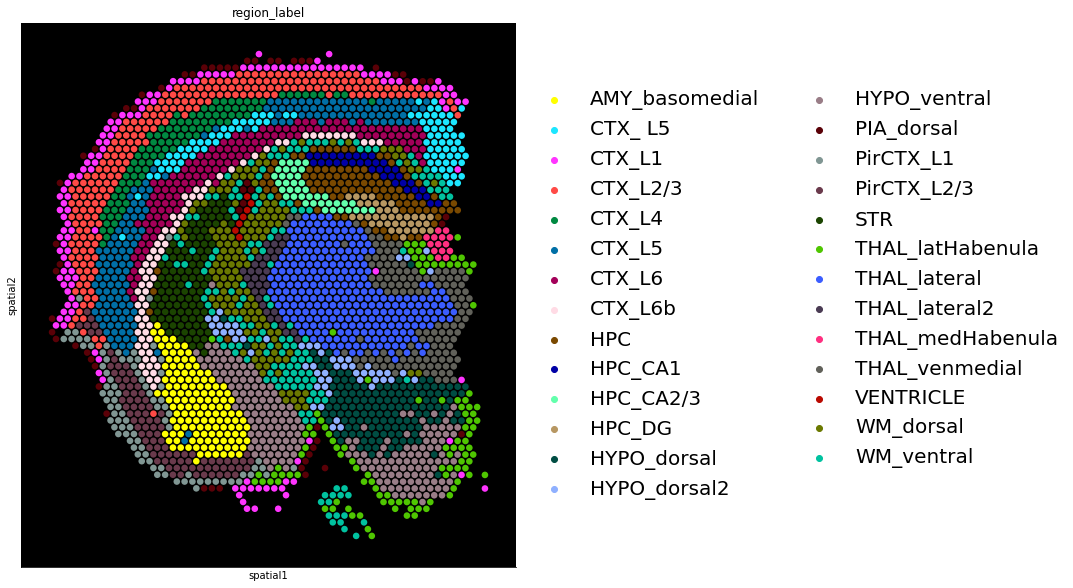

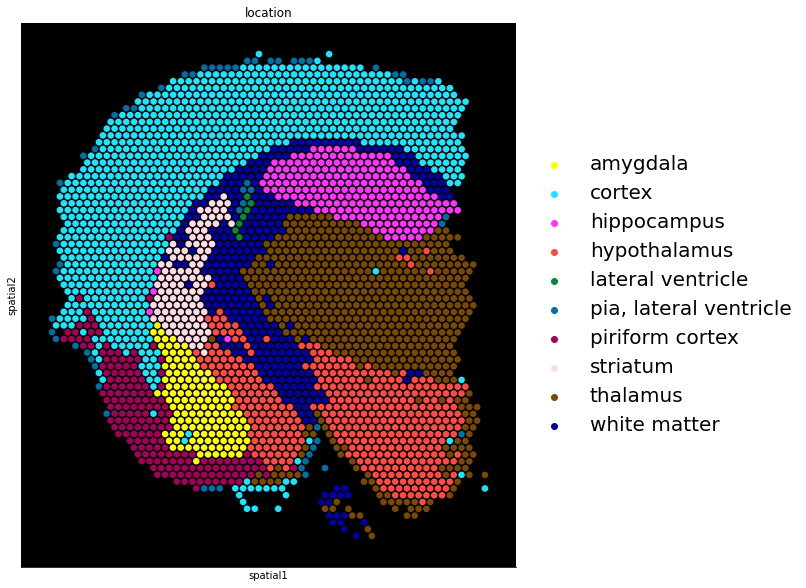

In [11]:
with matplotlib.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [10, 10]}):
    
    sel_clust = adata_vis.obs['region_label'].cat.categories.isin(slide.obs['region_label'].cat.categories)
    slide.uns['region_label_colors'] = list(np.array(adata_vis.uns['region_label_colors'])[sel_clust])
    sc.pl.spatial(slide, #cmap='magma',
                  color=['region_label'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_2D_final_clusters_one_section.pdf',
                  #palette=sc.pl.palettes.default_102
                 )
    
    sc.pl.spatial(slide, #cmap='magma',
                  color=['location'], ncols=4, 
                  #library_id=s,
                  size=1.3, img_key='hires', alpha_img=0,
                  frameon=True, legend_fontsize=20,
                  #crop_coord=crop_x + [crop_y[0]] + [crop_y[1]],
                  vmin=0, vmax='p99.5', save='Fig3E_suppl_2D_broad_locations_one_section.pdf',
                  palette=sc.pl.palettes.default_102
                 )

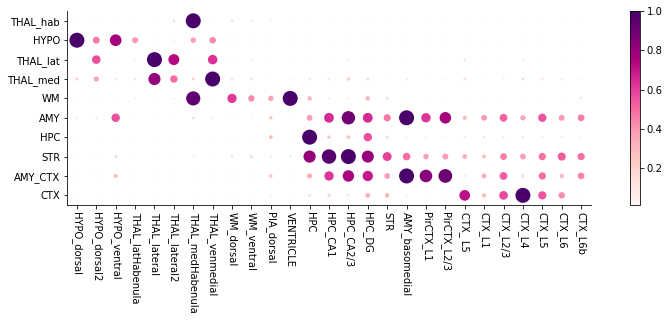

In [13]:
# load order of clusters and regions from R
ct_aver = pd.read_csv(f'{str(sc.settings.figdir)}/Fig3E_astro_location_pheatmap_one_section.csv',
                      index_col=0)
ct_aver = ct_aver[ct_aver.columns[::-1]]

with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=False, cluster_cols=False, figure_size=(12, 4.3), equal=True)
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_final_clusters_astro_dotplot_one_section.pdf',
                    bbox_inches='tight', facecolor='white')

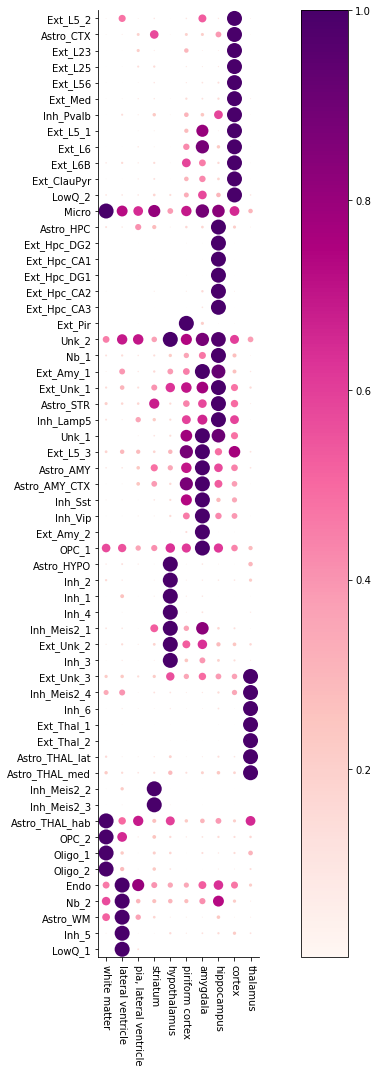

In [14]:
# Compute average abundance of each region cluster
from cell2location.cluster_averages.cluster_averages import get_cluster_averages_df
from cell2location.plt.plot_heatmap import clustermap
#plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
#plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

ct_aver = get_cluster_averages_df(X=adata_vis.obs[['mean_spot_factors' + i 
                                                      for i in adata_vis.uns['mod']['fact_names']]],
                        cluster_col=adata_vis.obs["location"])
ct_aver.index = adata_vis.uns['mod']['fact_names']
ct_aver.columns = ct_aver.columns

# normalise to get 10% of each cell type in each location
ct_aver = (ct_aver.T / ct_aver.max(1)).T
with matplotlib.rc_context({'axes.facecolor':  'white'}):
    clustermap(ct_aver, fun_type='dotplot',#.iloc[linkage['row_ord'], :],
               cluster_rows=True, cluster_cols=True, figure_size=(12, 15))
    plt.savefig(f'{str(sc.settings.figdir)}/Fig3E_suppl_location_dotplot_one_section.pdf',
                    bbox_inches='tight', facecolor='white')